# Compare own labelling against pupil algorithm 


## Import relevant packages

In [1]:
# Remove warnings
import warnings
warnings.filterwarnings("ignore")

# Import packages
import os
import pandas as pd
import numpy as np
import cv2
#import ffmpegcv 
from scipy import signal
from sys import platform
from itertools import compress 
from itertools import count
import glob


# Plotting thigs
import matplotlib.pyplot as plt
import matplotlib.patches as pltrec
from matplotlib.widgets import Slider, Button, CheckButtons
import ipympl

# Import the analysis functions 
import AnalysisTools as at

# Get system name 
SystemName  = platform

##########################################################################
## setting paths 
abspath = os.path.abspath('Main.ipynb') # Get the Path of this script
dname = os.path.dirname(abspath) # Get the directory
os.chdir(dname) # Set this to your current working directoy

## Now load the data

Data Structure should be as follows. Per Recording, there should be one folder that has the following files: 
1. gaze.csv 
2. imu.csv
3. world_timestamps.csv
4. world.mp4 (This file is typically named differently, for ease of use it should be renamed to world)



In [2]:
# Define the datapath to the data
Datapath = '../Data/' # Data should be a folder on the same level as the Code Folder

### Set the Name of the recording you want to analyze 
Rec = 'Subj46/Lego' # Subj35 High Amplitude 
                    # Subj46 min Amplitude
######################################################
# Get the behavioural data 
Eye = pd.read_csv(os.path.join(Datapath,Rec,'gaze.csv')) # Get the gaze position
Head = pd.read_csv(os.path.join(Datapath,Rec,'imu.csv')) # Get the Head position via the imu data
Video = pd.read_csv(os.path.join(Datapath,Rec,'world_timestamps.csv')) # Get the timestamps of the video 
LabelList = pd.read_json(os.path.join(Datapath,'panoptic_coco_categories.json')) # Read the list of the labels for Image Segmentation

# Find the video 
vidname = glob.glob(os.path.join(Datapath,Rec,'*.mp4'))
cap = cv2.VideoCapture(vidname[0]) # World Video



## Read out the variables you need for the analysis and compute velocities

Things you want to have: 
1. Gaze position in pixels and degrees and their sampling 
2. The head position in deg 

Then compute the eye and head velocity (this is already available for the head movements).
For computing the eye velocity, you want to add a filter to the gaze data to reduce noise.
Also get the sampling of the different components and align them on the same time scale.



In [3]:
""" This is for eye movements """

## Get the relevant Data 
xpos = Eye['gaze x [px]'].to_numpy() # Eye position in pixel x 
ypos = Eye['gaze y [px]'].to_numpy() # Eye position in pixel y 
xdeg = Eye['azimuth [deg]'].to_numpy() # Eye position in pixel x 
ydeg = Eye['elevation [deg]'].to_numpy() # Eye position in pixel y 
time_eye= Eye['timestamp [ns]'].to_numpy()/10**6 # Timestamps of the eye recording divided by 10^6 to turn it into ms

## Setup the Filter 
b,a = signal.butter(2, 20, 'low', fs=200, output='ba')

## Filter the eye data
xpos = signal.filtfilt(b,a,xpos) # Xpos in Pixel
ypos = signal.filtfilt(b,a,ypos) # Ypos in Pixel
xdeg = signal.filtfilt(b,a,xdeg) # Xpos in Deg
ydeg = signal.filtfilt(b,a,ydeg) # Ypos in Deg

## Compute the velocity 
# Velocity in deg per second
vel_x = at.HesselsVelocity(xdeg,time_eye)*1000 # Mulitply it by 1000 to make it deg/s
vel_y = at.HesselsVelocity(ydeg,time_eye)*1000 # Mulitply it by 1000 to make it deg/s
vel_eye = np.hypot(vel_x,vel_y)
#vel_eye = signal.filtfilt(b,a,vel_eye) # Xpos in Pixel

# Velocity in Pixel per second
vel_x_pix = at.HesselsVelocity(xpos,time_eye)*1000 # Mulitply it by 1000 to make it deg/s
vel_y_pix = at.HesselsVelocity(ypos,time_eye)*1000 # Mulitply it by 1000 to make it deg/s
vel_eye_pix = np.hypot(vel_x_pix,vel_y_pix)


## Correct for Blinks, in the raw file from Pupil Labls these are interpolated and existent
xpos[np.where(Eye['blink id'].notnull())] = np.nan
ypos[np.where(Eye['blink id'].notnull())] = np.nan
xdeg[np.where(Eye['blink id'].notnull())] = np.nan
ydeg[np.where(Eye['blink id'].notnull())] = np.nan
vel_eye[np.where(Eye['blink id'].notnull())] = np.nan
Blink_Vek = (Eye['blink id'].notnull())


In [4]:
""" This is for head movements """

PitchDeg = Head['pitch [deg]'].to_numpy() # Read out the positions in deg
YawDeg = Head['yaw [deg]'].to_numpy()
RollDeg = Head['roll [deg]'].to_numpy()
time_head = Head['timestamp [ns]'].to_numpy()/10**6

vx_head = Head['gyro z [deg/s]'].to_numpy() *-1 # The velocities are already available from the gyroscope
vy_head = Head['gyro x [deg/s]'].to_numpy()
vz_head = Head['gyro y [deg/s]'].to_numpy()

# To align the data with the video coordinate system you need to rotate the imu data by 102° around the x-axis 
# see https://docs.pupil-labs.com/neon/data-collection/data-streams/ for details 

theta = 102 
#vx_head = vx_head
#vy_head = vy_head*np.cos(np.radians(theta)) - vz_head*np.sin(np.radians(theta))
#vz_head = vy_head*np.sin(np.radians(theta)) + vz_head*np.cos(np.radians(theta))

#vy_head = vy_head
#vz_head = vx_head*np.cos(np.radians(theta)) - vz_head*np.sin(np.radians(theta))
#vx_head = vx_head*np.sin(np.radians(theta)) + vz_head*np.cos(np.radians(theta))

v_head = np.hypot(vx_head,vy_head) # 2d velocity in x and y plane relative to camera


In [5]:
## Align the timings 

time_video = Video['timestamp [ns]'].to_numpy()/10**6 # Get the timing from the video file 
NormTime = time_video[0] # Define a common start point, the initial frame of the eye recording 

# Update the time variables
time_eye = time_eye-NormTime 
time_video = time_video-NormTime


## Load the labels

In [6]:
## Load saccade labels from own algorithm
SaccOwn = pd.read_csv(os.path.join(Datapath,Rec,'SaccParam.csv'))
OnOwn = SaccOwn['Onset [ms]'].to_numpy()
OffOwn = SaccOwn['Offset [ms]'].to_numpy()
AmplitudeOwn = SaccOwn['Saccade Amplitude [deg]'].to_numpy()

BlinkOwn = pd.read_csv(os.path.join(Datapath,Rec,'BlinkParam.csv'))
BlinkOn = BlinkOwn['Onset [ms]'].to_numpy()
BlinkOff = BlinkOwn['Offset [ms]'].to_numpy()
BlinkAmp = BlinkOwn['Blink Amplitude [deg]'].to_numpy()

# Add the blinks to the saccade 

# OnOwn = 0
# OffOwn = 0
# AmplitudeOwn = 0
# OnOwn = np.hstack((OnOwn, BlinkOn))
# OffOwn = np.hstack((OffOwn, BlinkOff))
# AmplitudeOwn = np.hstack((AmplitudeOwn, BlinkAmp))

## Load Saccades from pupil algorithm 
SaccPupil = pd.read_csv(os.path.join(Datapath,Rec,'saccades.csv'))
OnPupil = (SaccPupil['start timestamp [ns]'].to_numpy()/10**6)-NormTime
OffPupil = (SaccPupil['end timestamp [ns]'].to_numpy()/10**6)-NormTime
AmplitudePupil = SaccPupil['amplitude [deg]'].to_numpy()


### Visualize the movement labeling 

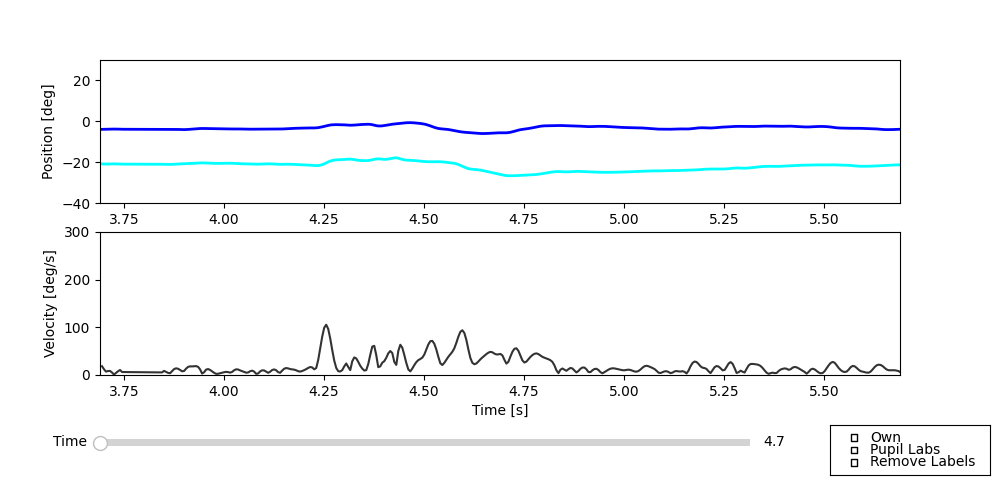

In [7]:
# Visualize things
%matplotlib widget
at.CompareLabels(time_eye,xdeg,ydeg,vel_eye,OnOwn,OffOwn,OnPupil,OffPupil)


## Look at the individual saccades and compare them

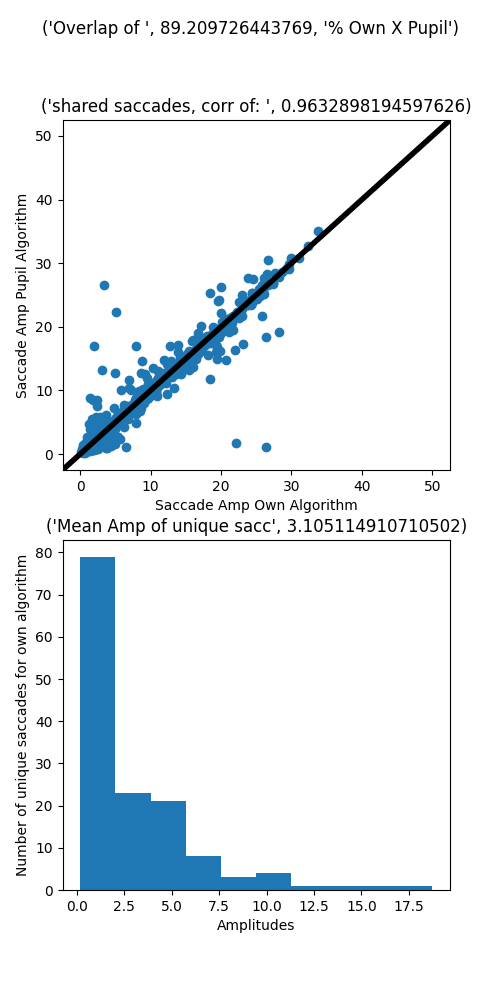

In [8]:
## Find similarities in saccades based on own algorihtm

SaccShared = np.zeros((len(AmplitudeOwn),2)); 
SaccShared[:,0] = AmplitudeOwn

for aa,bb in enumerate(OnOwn): 
    idx = (np.where((bb > OnPupil-100) & (bb < OnPupil+100)))
    if len(idx[0]) > 0:
        SaccShared[aa,1]= AmplitudePupil[np.min(idx)]

## Now visualize the results

plt.close('all')
SaccCom= SaccShared[SaccShared[:,1]>0,:] # Find the ones where you have an equivalent
SaccCom= SaccCom[~np.isnan(SaccCom[:,0]),:] # Find the ones where you have an equivalent
SaccDiff = SaccShared[SaccShared[:,1]==0,:] # Find the ones where you dont have an equivalent

corr = np.corrcoef(SaccCom[:,0],SaccCom[:,1],'full')

fig, (ax1,ax2) = plt.subplots(2,figsize=(5,10)) # Create a figure
fig.suptitle(('Overlap of ', len(SaccCom)/len(SaccShared)*100, '% Own X Pupil'))
ax1.plot(SaccCom[:,0],SaccCom[:,1],'o')
ax1.plot([0,0],[50, 50],'k-')
ax1.axline((0,0),(50, 50),linewidth=4,color='k')
ax1.set_xlabel('Saccade Amp Own Algorithm')
ax1.set_ylabel('Saccade Amp Pupil Algorithm')
ax1.title.set_text(('shared saccades, corr of: ',corr[0,1]))

ax2.hist(SaccDiff[:,0])
ax2.set_xlabel('Amplitudes')
ax2.set_ylabel('Number of unique saccades for own algorithm')
ax2.title.set_text(('Mean Amp of unique sacc',np.nanmean(SaccDiff[:,0])))

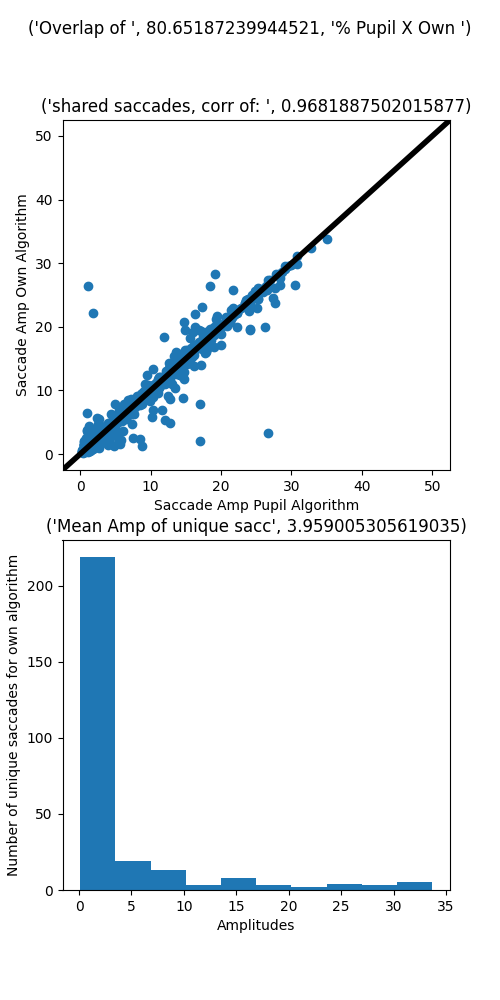

In [10]:
## Find similarities in saccades based on own pupil algorithm

SaccSharedPup = np.zeros((len(AmplitudePupil),2)); 
SaccSharedPup[:,0] = AmplitudePupil

for aa,bb in enumerate(OnPupil): 
    idx = (np.where((bb > OnOwn-100) & (bb < OnOwn+100)))
    if len(idx[0]) > 0:
        SaccSharedPup[aa,1]= AmplitudeOwn[np.min(idx)]

SaccComPup= SaccSharedPup[SaccSharedPup[:,1]>0,:] # Find the ones where you have an equivalent
SaccComPup= SaccComPup[~np.isnan(SaccComPup[:,0]),:] # Find the ones where you have an equivalent
SaccDiffPup = SaccSharedPup[SaccSharedPup[:,1]==0,:] # Find the ones where you dont have an equivalent

corr = np.corrcoef(SaccComPup[:,0],SaccComPup[:,1],'full')

fig, (ax1,ax2) = plt.subplots(2,figsize=(5,10)) # Create a figure
fig.suptitle(('Overlap of ', len(SaccComPup)/len(SaccSharedPup)*100, '% Pupil X Own '))
ax1.plot(SaccComPup[:,0],SaccComPup[:,1],'o')
ax1.plot([0,0],[50, 50],'k-')
ax1.axline((0,0),(50, 50),linewidth=4,color='k')
ax1.set_xlabel('Saccade Amp Pupil Algorithm')
ax1.set_ylabel('Saccade Amp Own Algorithm')
ax1.title.set_text(('shared saccades, corr of: ',corr[0,1]))

ax2.hist(SaccDiffPup[:,0])
ax2.set_xlabel('Amplitudes')
ax2.set_ylabel('Number of unique saccades for own algorithm')
ax2.title.set_text(('Mean Amp of unique sacc',np.nanmean(SaccDiffPup[:,0])))

In [11]:
print(np.nanmedian(AmplitudeOwn))
print(np.nanmedian(AmplitudePupil))

3.941257441537523
3.46472188697109


(array([ 83., 241., 168., 147.,  97.,  72.,  53.,  57.,  51.,  41.,  26.,
         31.,  26.,  23.,  26.,  23.,  26.,  12.,  17.,  19.,  18.,  19.,
         12.,  10.,  16.,  16.,  12.,   9.,   5.,   6.,   8.,   7.,   1.,
          8.,   7.,  10.,   6.,   6.,   2.,   4.,   6.,   4.,   1.,   4.,
          0.,   1.,   1.,   2.,   1.,   1.]),
 array([ 0.10421034,  0.80375616,  1.50330197,  2.20284779,  2.90239361,
         3.60193942,  4.30148524,  5.00103106,  5.70057687,  6.40012269,
         7.09966851,  7.79921432,  8.49876014,  9.19830596,  9.89785178,
        10.59739759, 11.29694341, 11.99648923, 12.69603504, 13.39558086,
        14.09512668, 14.79467249, 15.49421831, 16.19376413, 16.89330994,
        17.59285576, 18.29240158, 18.99194739, 19.69149321, 20.39103903,
        21.09058484, 21.79013066, 22.48967648, 23.18922229, 23.88876811,
        24.58831393, 25.28785974, 25.98740556, 26.68695138, 27.38649719,
        28.08604301, 28.78558883, 29.48513464, 30.18468046, 30.88422628,
 

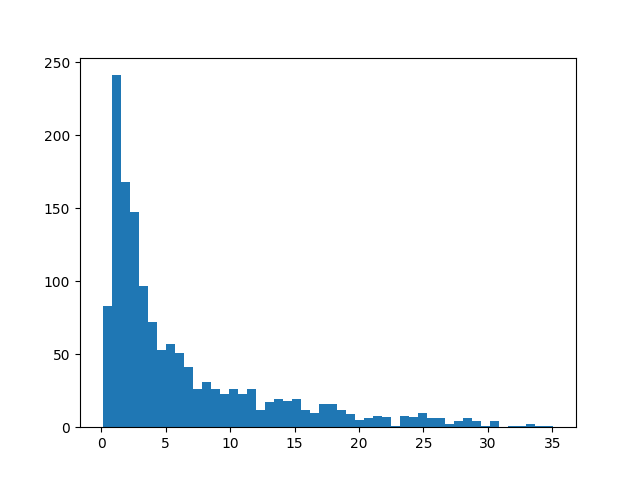

In [261]:
plt.figure()
plt.hist(AmplitudePupil,50)

(array([ 32., 138., 187., 156.,  93.,  67.,  68.,  62.,  44.,  39.,  31.,
         36.,  27.,  23.,  25.,  22.,  27.,  22.,  11.,  13.,  15.,   8.,
         19.,   7.,  13.,  12.,   9.,  13.,  11.,  11.,   7.,   6.,   6.,
          7.,   4.,   5.,   8.,   6.,   6.,   5.,   2.,   4.,   1.,   4.,
          1.,   0.,   1.,   0.,   1.,   1.]),
 array([ 0.13409354,  0.80595449,  1.47781544,  2.14967638,  2.82153733,
         3.49339828,  4.16525923,  4.83712018,  5.50898112,  6.18084207,
         6.85270302,  7.52456397,  8.19642491,  8.86828586,  9.54014681,
        10.21200776, 10.88386871, 11.55572965, 12.2275906 , 12.89945155,
        13.5713125 , 14.24317344, 14.91503439, 15.58689534, 16.25875629,
        16.93061724, 17.60247818, 18.27433913, 18.94620008, 19.61806103,
        20.28992197, 20.96178292, 21.63364387, 22.30550482, 22.97736577,
        23.64922671, 24.32108766, 24.99294861, 25.66480956, 26.3366705 ,
        27.00853145, 27.6803924 , 28.35225335, 29.0241143 , 29.69597524,
 

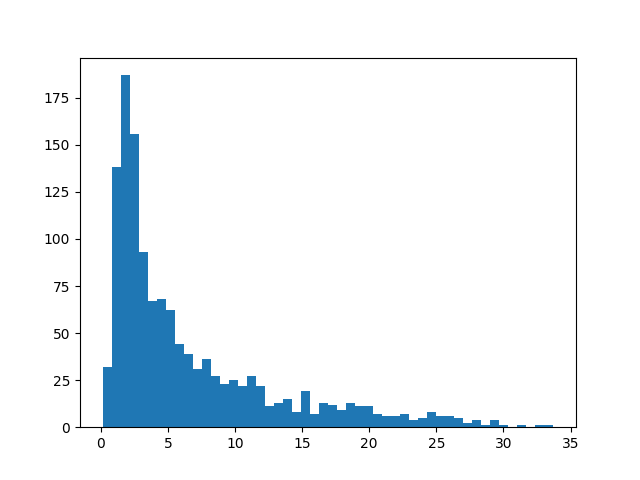

In [12]:
plt.figure()
plt.hist(AmplitudeOwn,50)